# Predicting who survived in the Titanic dataset

As one of the exercises in the "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" book by Aurelien Geron, in this notebook I will be trying to tackle the famous Titanic dataset. 

First, it's important to understand what every variable means:

**Data dictionary**:
1. Survived: If the person survived; 0 = No and 1 = Yes
2. Pclass: Socio-economic status; 1 = 1st, 2 = 2nd and 3 = 3rd class
3. Sex: Sex of the person (biological)
4. Age: Age in years
5. SibSp: Number of siblings / spouses aboard the Titanic
6. Parch: Number of parents / children aboard the Titanic
7. Ticket: Ticket number
8. Fare: Passenger fare
9. Cabin: Cabin number
10. Embarked: Port of Embarkation; C = Cherbourg, Q = Queenstown and S = Sohampton



We start by importing the standard modules:

__Note:__ I'm aware that it's better to import all the modules that I'm going to use at the beginning of the notebook but as this is itended to be a step-by-step guide, we're going to import every module as we need them

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as 
import re

Now, let's create a function to load the data, which is a best practice compared to downloading and extracting it manually every time.

In [2]:
from pathlib import Path
import urllib
import tarfile

def load_data():
    data_path = Path("datasets/titanic.tgz")
    if not data_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://homl.info/titanic.tgz"
        urllib.request.urlretrieve(url, data_path)
        with tarfile.open(data_path) as tar:
            tar.extractall(path="datasets")
    test = pd.read_csv(Path("datasets/titanic/test.csv")).set_index("PassengerId")
    train = pd.read_csv(Path("datasets/titanic/train.csv")).set_index("PassengerId")
    return test, train
test_data, train_data = load_data()    

In [3]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## EDA

Here, we'll perform a basic exploration of the data, see if there's missing values, find interesting relations, etc.

In [4]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


There's some missing values for Age and Embarked, and a loooooooot of missing values for Cabin so we'll need to find a way to impute them or decide to drop them.

In [6]:
train_data.Sex.value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [7]:
train_data.Embarked.value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [8]:
train_data.Pclass.value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

As there's an order relationship between the classes in Pclass, we could leave the variables as there already are (No need for one-hot-encoding) but for Embarked and Sex it might be useful to perform an encoding

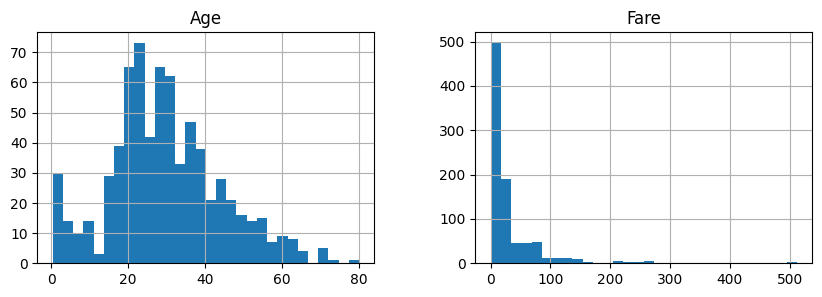

In [9]:
train_data.hist(bins=30, column=["Age", "Fare"], figsize=(10,3));

We are going to group the values for Age and Fare into buckets corresponding to the percentiles of the distribution. Another strategy could be to use a RobustScaler.

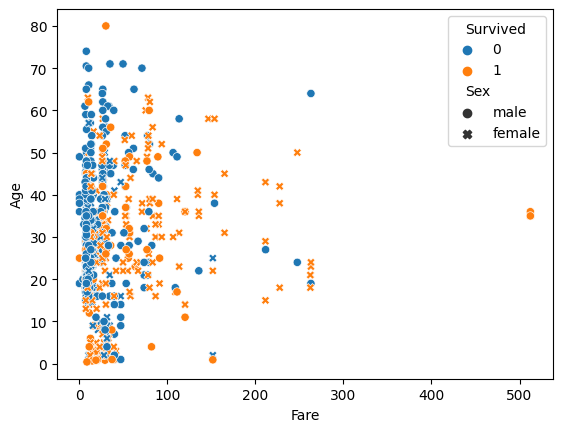

In [10]:
sns.scatterplot(data=train_data, x="Fare", y="Age", hue="Survived", style="Sex");

We can notice that a los of the people that survived were females, and that the people who died, in general, were people whose tickets were cheaper. Another important thing to note is that kid and babies survivedno matter what the price of their ticket was.

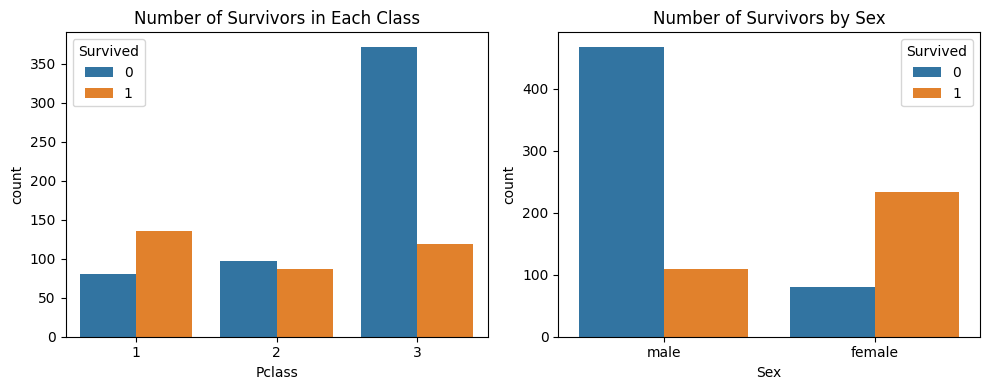

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

sns.countplot(data=train_data, x='Pclass', hue='Survived', ax=axes[0])
axes[0].set_title("Number of Survivors in Each Class")

sns.countplot(data=train_data, x='Sex', hue='Survived', ax=axes[1])
axes[1].set_title("Number of Survivors by Sex")

plt.tight_layout()

Now we can see more clearly that for people in the 3rd class the probability of surviving was much lower than for those in higher classes. Also, regarding sex, the probability of surviving for a females was pretty favorable compared to the one for males.

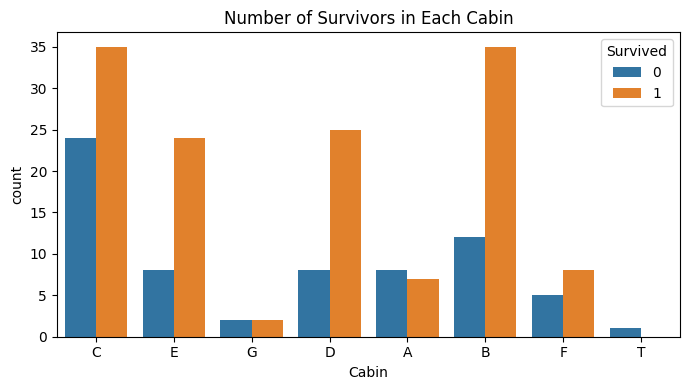

In [12]:
cabin_letter = train_data["Cabin"].str[0]

plt.figure(figsize=(7,4))
sns.countplot(data=train_data, x=cabin_letter, hue='Survived')
plt.title("Number of Survivors in Each Cabin")
plt.tight_layout()

So, apparently something that a lot of people do with this dataset is that they use the cabin variable but just considering the first letter, which comess to be some sort of cabin group. Doing this makes you realize that this variable is important since theres cabin groups where the probabilities of survival were very good. For the pipelines we are going to use an imputer that creates an artificial cabin group for those who had a missing value in this variable, and for those who had the cabin name we'll use its group.

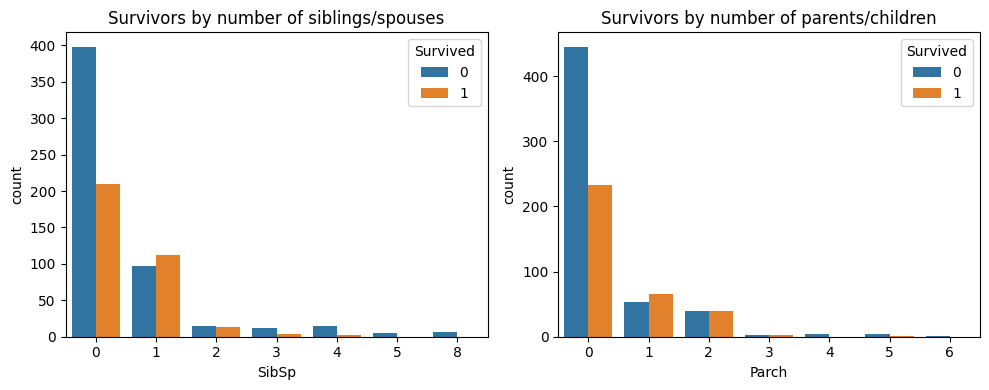

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

sns.countplot(data=train_data, x='SibSp', hue='Survived', ax=axes[0])
axes[0].set_title("Survivors by number of siblings/spouses")

sns.countplot(data=train_data, x='Parch', hue='Survived', ax=axes[1])
axes[1].set_title("Survivors by number of parents/children")

plt.tight_layout()

It looks like having 1 to 2 siblings/spouses and 1 to 3 parents/children somwhow helped people to improve their chances of surviving.

__Note:__ We are going to talk about correlations after doing the preprocessing

## Preprocessing

Let's build some pipelines to handle the preprocessing of the data. Here we'll have some functions that help us impute the missing data, scale the actual data and also create new variables.

We have to import useful modules to create our custom transformers

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [297]:
class Impute_Cabin(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        if X.shape[1] != 1:
            raise ValueError("Transformer made just for Cabin column")
        self.n_features_in_ = X.shape[1]
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns.to_numpy()
        return self
        
    def transform(self, X):
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features")
        X = pd.DataFrame(X)
        X = X.iloc[:, 0].fillna(value="Z") # artificial value
        return X.str[0]# first letter
        
    def get_features_names_out(self, input_features=None):
        return ["cabin_group"]

class Names_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_lucky_last_names=32):
        self.num_lucky_last_names = num_lucky_last_names
        
    def fit(self, X, y):
        if X.shape[1] != 1:
            raise ValueError("Transformer made just for Name column")
        self.n_features_in_ = X.shape[1]
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns.to_numpy()
        X = pd.DataFrame(X)
        X = X.iloc[:, 0]
        y = pd.DataFrame(y)

        last_names = X.apply(lambda x: re.split(r"[,.]", x)[0])
        freq_last_names = last_names.value_counts().to_dict()
        aux_table = pd.concat([last_names, y], axis=1)
        aux_table['freq'] = last_names.map(freq_last_names)

        survive_vs_lastnames = aux_table.groupby('Name')['Survived'].mean()
        lucky = (survive_vs_lastnames > 0.90).to_dict()
        aux_table['lucky'] = last_names.map(lucky)

        self.lucky_names_ = aux_table\
            .drop_duplicates()\
            .query('freq >= 2 & lucky')\
            .sort_values("freq", ascending=False)\
            .iloc[:self.num_lucky_last_names]["Name"]\
            .str.strip()\
            .values
        return self
        
    def transform(self, X):
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features")
        X = pd.DataFrame(X)
        X = X.iloc[:, 0]
        
        names_titles = X.apply(lambda x: re.split(r"[,.]", x)[:2])
        names_titles = pd.DataFrame(names_titles.tolist(), 
                                    columns=['last_name', 'title'])
        
        names_titles.title = names_titles.title.str.strip()
        names_titles.last_name = names_titles.last_name.str.strip()

        names_titles.title.loc[~names_titles["title"]\
            .isin(["Mr","Master","Miss","Mrs"])] = "Other"
        
        is_lucky = {x: '1' if x in self.lucky_names_ else '0' for x in names_titles.last_name}
        names_titles.last_name = names_titles.last_name.map(is_lucky)

        return pd.concat([names_titles.last_name, names_titles.title], axis=1).values

    def get_features_names_out(self, input_features=None):
        return ["lucky_name", "title"]

The first transformer just gives us the first letter of the cabin as we discussed earlier, replacing the missing values with an artificial letter (Z). The second transformer creates 2 variables, the first one called "lucky_name" is 1 if there were more than 2 persons with that last name that survived; I did this because it's reasonable to think that families with more power are the ones that survived with more ease than others, so having a specific last name can tell you a lot if the person survived or not. It also creates the "title" variable that tells you if the person appeared as a Mr, a Master, Miss or Mrs. There were more titles but I only gave importace to these because they were the ones that appeared the most, there were also titles like Dr., Rev., etc. but i didn't include them because there weren't many people holding them.

Let's see if the transformers we built are working correctly

In [298]:
ic = Impute_Cabin()
ic.fit_transform(train_data[["Cabin"]])

PassengerId
1      Z
2      C
3      Z
4      C
5      Z
      ..
887    Z
888    B
889    Z
890    C
891    Z
Name: Cabin, Length: 891, dtype: object

In [299]:
nt = Names_Transformer()
nt.fit_transform(train_data[["Name"]], train_data.Survived)

array([['0', 'Mr'],
       ['0', 'Mrs'],
       ['0', 'Miss'],
       ...,
       ['0', 'Miss'],
       ['0', 'Mr'],
       ['0', 'Mr']], dtype=object)

In [300]:
train_data.Name

PassengerId
1                                Braund, Mr. Owen Harris
2      Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                 Heikkinen, Miss. Laina
4           Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                               Allen, Mr. William Henry
                             ...                        
887                                Montvila, Rev. Juozas
888                         Graham, Miss. Margaret Edith
889             Johnston, Miss. Catherine Helen 'Carrie'
890                                Behr, Mr. Karl Howell
891                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object